In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hope = pd.read_csv('./data/데이터_희망도서.csv',encoding='CP949')
bookloan = pd.read_csv('./data/데이터_단행본대출.csv',encoding='CP949')
bookinfo = pd.read_csv('./data/데이터_단행본도서.csv',encoding='CP949')
bookres = pd.read_csv('./data/데이터_단행본예약.csv',encoding='CP949')
loan = pd.read_csv('./data/대출 희망 예약 분위수/도서대출분위수.csv',encoding = 'CP949')
res = pd.read_csv('./data/대출 희망 예약 분위수/도서예약분위수.csv',encoding = 'CP949')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


- 레이팅 다시 (아이템용)
	최종안
	유저
		연장 + 1
		소속(분위수) + 1
	도서
		자료계열 +예약+대출(7,5,3 합쳐서 1.5점)
		등록일자 + 출판연도  1
		수서구분 (0.5)
		

In [ ]:
#@title 자료계열 dic
dic = {'국어국문학과': ['인문'],
       '기독교학과': ['인문'],
       '독어독문학과': ['인문'],
       '불어불문학과': ['인문'],
       '사학과': ['인문'],
       '스포츠학부': ['인문'],
       '영어영문학과': ['인문'],
       '일어일문학과': ['인문'],
       '중어중문학과': ['인문'],
       '철학과': ['인문'],
       'AI융합학부': ['자연'],
       '건축학부': ['자연'],
       '기계공학부': ['자연'],
       '물리학과': ['자연'],
       '산업·정보시스템공학과': ['자연'],
       '소프트웨어학부': ['자연'],
       '수학과': ['자연'],
       '유기신소재·파이버공학과': ['자연'],
       '의생명시스템학부': ['자연'],
       '전기공학부': ['자연'],
       '전자정보공학부 IT융합전공': ['자연'],
       '전자정보공학부 전자공학전공': ['자연'],
       '정보통계·보험수리학과': ['자연'],
       '정보통신전자공학부': ['자연'],
       '컴퓨터학부': ['자연'],
       '화학공학과': ['자연'],
       '화학과': ['자연'],
       '예술창작학부 문예창작전공': ['인문','문학'],
       '예술창작학부 영화예술전공': ['인문','문학'],
       '경영학부': ['사회'],
       '경제학과': ['사회'],
       '국제무역학과': ['사회'],
       '글로벌통상학과': ['사회'],
       '금융경제학과': ['사회'],
       '금융학부': ['사회'],
       '벤처경영학과(계약학과)': ['사회'],
       '벤처중소기업학과': ['사회'],
       '복지경영학과(계약학과)': ['사회'],
       '혁신경영학과(계약학과)': ['사회'],
       '회계학과': ['사회'],
       '사회복지학부': ['사회','자연'],
       '글로벌미디어학부': ['사회','자연'],
       '미디어경영학과': ['사회','자연'],
       '언론홍보학과': ['사회','자연'],
       '융합특성화자유전공학부': ['사회','자연'],
       '정보사회학과': ['사회','자연'],
       '정치외교학과': ['사회','자연'],
       '평생교육학과': ['사회','자연'],
       '행정학부': ['사회','자연'],
       '국제법무학과': ['인문','사회'],
       '법학과': ['인문','사회']}
info_dic = {'기증도서': 0.3, '희망도서':0.5, '학과도서':0.4, '지정도서':0.1, '신간도서':0.5, '참고도서':0.2, '특수도서':0}
extend_dic = {'연장':1,'대출':0}

In [ ]:
def preprocess(bookloan,bookinfo):
  # 소속이 숭실대인거
  bookloan = bookloan[bookloan['소속']!='숭실대학교']
  bookinfo['year'] = bookinfo.등록일자.apply(lambda x : x[:4])
  df = pd.merge(bookloan,right = bookinfo[['등록번호','year','수서구분','자료계열','출판년도','소장위치']], on = '등록번호',how = 'left')
  df.fillna('0',inplace = True)
  df = df[(df['year'].astype(int) >= 1997) & (df['year'].astype(int)<=2022)]


  a = list(range(1997,2023))
  a = list(map(str,a))
  
  #출판년도가 이상한 데이터
  new_df = df[df['출판년도'].str.contains(a[0])==True]
  for i in range(1,len(a)):
    sp = df[df['출판년도'].str.contains(a[i])==True]
    new_df = pd.concat([new_df,sp],axis = 0)
  
  # 유저키, 아이템키, 연장, 수서구분rating
  new_df['user'] = new_df['입학년도'].astype(str) +'-'+ new_df['소속'].astype(str)+':'+ new_df['연대출권수'].astype(str)
  return new_df

In [ ]:
new_df = preprocess(bookloan,bookinfo)

### Missing value
<처리내용>
  - 숭실대
  - 등록일자 1997~2022

In [ ]:
new_df

,대출일시,반납일시,등록번호,ISBN,서명,대출연장구분,연대출권수,입학년도,소속,상위소속,year,수서구분,자료계열,출판년도,소장위치,user,연장_rating,수서구분_rating
71,2017/03/06 00:14:11,2017/03/13 00:00:00,E217848,9788912115050,가족 시네마,연장,114,2014,예술창작학부 문예창작전공,인문대학,1997,기증도서,문학,1997,5층 문학자료실,2014-예술창작학부 문예창작전공:114,1,0.3
676,2017/03/08 14:23:07,2017/03/22 00:00:00,E230327,9788970922034,일리아스,연장,51,2014,독어독문학과,인문대학,1997,기증도서,문학,1997,보존서고-지하1층(S),2014-독어독문학과:51,1,0.3
1279,2017/03/02 12:30:00,2017/04/17 00:00:00,E228034,9788971630662,기초 전자 회로 실험,대출,62,2011,전자정보공학부 IT융합전공,IT대학,1997,기증도서,자연,1997,6층 자연과학실,2011-전자정보공학부 IT융합전공:62,0,0.3
1608,2017/03/02 13:14:25,2017/03/06 00:00:00,E514713,9788931003116,임마누엘 칸트,대출,3,2010,영어영문학과,인문대학,2011,희망도서,인문,1997,4층 인문과학실,2010-영어영문학과:3,0,0.5
1775,2017/03/02 14:06:15,2017/03/17 00:00:00,E602448,9788973400539,시련은 있어도 실패는 없다,대출,4,2010,경영학부,경영대학,2013,희망도서,사회,1997,3층 사회과학실,2010-경영학부:4,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581251,2022/02/23 14:15:43,2022/03/25 18:09:16,E848839,9791191600650,프로그래머의 뇌,대출,87,2014,전자정보공학부 전자공학전공,IT대학,2022,희망도서,자연,2022,6층 자연과학실,2014-전자정보공학부 전자공학전공:87,0,0.5
581370,2022/02/25 14:11:48,2022/03/03 14:07:07,E848897,9791191043631,잘 살아라 그게 최고의 복수다,대출,87,2014,전자정보공학부 전자공학전공,IT대학,2022,학과도서,인문,2022,4층 인문과학실,2014-전자정보공학부 전자공학전공:87,0,0.4
581395,2022/02/25 16:30:13,2022/03/08 16:23:41,E849410,9788901255712,세븐 테크 :3년 후 당신의 미래를 바꿀 7가지 기술,대출,6,2017,예술창작학부 영화예술전공,인문대학,2022,학과도서,사회,2022,3층 사회과학실,2017-예술창작학부 영화예술전공:6,0,0.4
581431,2022/02/28 13:03:06,2022/03/28 13:17:41,E847740,9791197549335,전념 :나와 세상을 바꾸는 힘에 관하여,대출,46,2018,소프트웨어학부,IT대학,2022,희망도서,인문,2022,4층 인문과학실,2018-소프트웨어학부:46,0,0.5


## Rating 작업
- 최종 실행 코드 : create_rating


<하위 함수>
  - year_credit
  - info_credit  
  - major_credit

In [ ]:
def year_credit(s:pd.DataFrame):
  con=[
      (s.astype(int) >= 2017),
      (s.astype(int) >= 2012),
      (s.astype(int) >= 2007),
      (s.astype(int) >= 2002),
      (s.astype(int) >= 1997)
  ]
  r_2=[0.5, 0.4,0.3,0.2,0.1]
  
  return np.select(con, r_2)

In [ ]:
# 소속의 계열추가하고
# 자료계열에 포함 되는지 확인하는 절차
def info_credit(new_df,dic):
  def f(x:str,y:list):
    for i in y:
      if i == x:
        return 0.7
    return 0
  df = new_df.copy()
  df['소속_계열'] = df['소속'].map(dic)
  a = list(map(f,df['자료계열'],df['소속_계열']))
  df['계열_rating'] = a
  return df['계열_rating']

In [ ]:
def major_credit(temp):
  #소속 평점
  major_list = temp['소속'].unique()
  temp3 = temp.copy()
  for i in major_list:
    globals()[str(i)] = pd.read_csv('./data/과대출분위수/{}분위수.csv'.format(i),encoding = 'cp949') #각자 경로로 바꿔서 진행
    globals()[str(i)].columns = ['서명',str(i)]
    temp3 = pd.merge(temp3,globals()[str(i)],on = '서명',how ='left')
  temp3.fillna(0,inplace = True) # temp2의 대출, 예약, 희망 평점 데이터와 merge


  def f(x,y):
    return temp3[x][y]
  a = pd.Series(map(f,temp3['소속'],list(temp3.index)))
  temp3['소속_rating'] = a/5 # 1점 만점
  return temp3['소속_rating']

rating_모두 통합

In [ ]:
def create_rating(new_df,res,loan):
  # new_df
    # 연장여부 1점 만점
    # 수서구분 0.5점 만점
    
    # 예약 0.5점
    # 대출 0.3점
    
    # 소속 1점
    # 자료계열 0.7점 

    # 출판년도, 대출일자 1점
    # 총합 = 1+0.5+0.5+0.3+1+0.7+1 = 5점
  # 연장 여부
  new_df['연장_rating'] = new_df['대출연장구분'].map(extend_dic)
  
  # 수서 구분
  new_df['수서구분_rating'] = new_df['수서구분'].map(info_dic)

  # 예약 분위수
  res_1 = res.copy()
  res_1['예약_rating'] = res_1['예약분위수'] / 10 # 0.5점 만점
  del res_1['예약분위수']
  del res_1['서명']

  # 대출 분위수
  loan_1 = loan.copy()
  loan_1['대출_rating'] = loan_1['대출분위수']* (3/50)  # 0.3점 만점
  del loan_1['대출분위수']
  del loan_1['서명']


  # year_credit
  new_df["출판년도_rating"] = year_credit(new_df['출판년도'])  # 0.5 만점
  new_df["year_rating"] = year_credit(new_df['year'])     # 0.5 만점

  # major create 소속_rating
  new_df['소속_rating'] = major_credit(new_df)             # 소속 1점 만점

  # info create 자료_rating
  new_df['자료_rating'] = info_credit(new_df,dic)          # 자료계열 0.7점 만점




  rating = new_df.copy()

  # user, item, rating만 있는 최종 평점으로 변경
  rating = pd.merge(rating,res_1,on='등록번호',how='left')
  rating = pd.merge(rating,loan_1,on='등록번호',how='left')
  rating.fillna(0,inplace = True)

  rating['rating'] = rating['자료_rating'] + rating['대출_rating'] 
                  + rating['예약_rating'] + rating['출판년도_rating'] 
                  + rating['year_rating'] + rating['소속_rating'] 
                  + rating['연장_rating'] + rating['수서구분_rating']
  uir_df = rating[['user','등록번호','rating']]
  uir_df.columns = ['user','item','rating']
  uir_df.reset_index(drop = True, inplace = True)
  
  del new_df
  del loan_1
  del res_1
  del rating

  return uir_df

In [ ]:
test = create_rating(new_df,res,loan)

In [ ]:
test

,user,item,rating
0,2014-예술창작학부 문예창작전공:114,E217848,3.06
1,2014-독어독문학과:51,E230327,1.82
2,2011-전자정보공학부 IT융합전공:62,E228034,1.80
3,2010-영어영문학과:3,E514713,3.24
4,2010-경영학부:4,E602448,2.94
...,...,...,...
566870,2014-전자정보공학부 전자공학전공:87,E848839,2.26
566871,2014-전자정보공학부 전자공학전공:87,E848897,1.46
566872,2017-예술창작학부 영화예술전공:6,E849410,1.56
566873,2018-소프트웨어학부:46,E847740,1.66


In [ ]:
test.describe()

,rating
count,566875.000000
mean,3.082996
std,0.764805
min,0.560000
25%,2.520000
50%,3.100000
75%,3.600000
max,5.000000


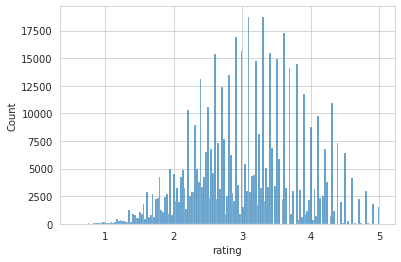

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.histplot(test.rating)

In [ ]:
test.to_csv('/content/drive/MyDrive/SSU데이터톤/data/final/final_uir_df.csv')